In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

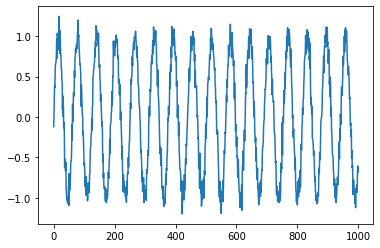

In [2]:
# make the original data
N = 1000
series = np.sin(0.1 * np.arange(N)) + np.random.randn(N) * 0.1

# plot it
plt.plot(series)
plt.show()

In [3]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T) 
Y = np.array(Y).reshape(-1, 1)
N = len(X) 
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10) Y.shape (990, 1)


In [4]:
### try autoregressive linear model
model = nn.Linear(T, 1)

In [5]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [6]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
Y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
Y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [7]:
# Train the model
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            Y_train,
            X_test,
            Y_test,
            epochs=200):

    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Save losses
        train_losses[it] = loss.item()

        # Test losses
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, Y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 10 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

In [8]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    Y_train,
                                    X_test,
                                    Y_test)

Epoch 10/200, Train Loss: 0.0780, Test Loss: 0.0252
Epoch 20/200, Train Loss: 0.0618, Test Loss: 0.0504
Epoch 30/200, Train Loss: 0.0240, Test Loss: 0.0269
Epoch 40/200, Train Loss: 0.0184, Test Loss: 0.0196
Epoch 50/200, Train Loss: 0.0158, Test Loss: 0.0158
Epoch 60/200, Train Loss: 0.0157, Test Loss: 0.0152
Epoch 70/200, Train Loss: 0.0152, Test Loss: 0.0146
Epoch 80/200, Train Loss: 0.0148, Test Loss: 0.0142
Epoch 90/200, Train Loss: 0.0145, Test Loss: 0.0141
Epoch 100/200, Train Loss: 0.0143, Test Loss: 0.0140
Epoch 110/200, Train Loss: 0.0142, Test Loss: 0.0139
Epoch 120/200, Train Loss: 0.0140, Test Loss: 0.0138
Epoch 130/200, Train Loss: 0.0139, Test Loss: 0.0138
Epoch 140/200, Train Loss: 0.0138, Test Loss: 0.0138
Epoch 150/200, Train Loss: 0.0138, Test Loss: 0.0138
Epoch 160/200, Train Loss: 0.0137, Test Loss: 0.0138
Epoch 170/200, Train Loss: 0.0137, Test Loss: 0.0138
Epoch 180/200, Train Loss: 0.0137, Test Loss: 0.0139
Epoch 190/200, Train Loss: 0.0136, Test Loss: 0.0139
Ep

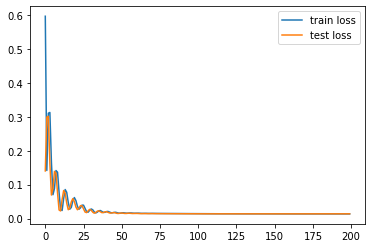

In [9]:
# Plot the train and test losses per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [10]:
# "Wrong" forecast using true targets
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].view(1, -1)
    p = model(input_)[0,0].item() # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

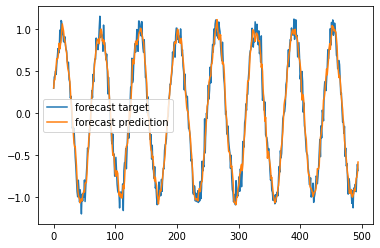

In [11]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

In [12]:
# Forecast future values (use only self-predictions for making future predictions)
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions) < len(validation_target):
    input_ = last_x.view(1, -1)
    p = model(input_) 
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p)

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

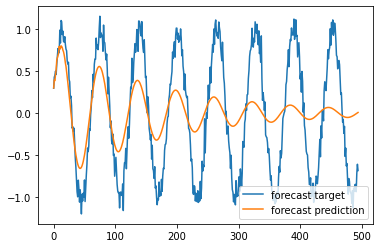

In [13]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()